# Calibration notebook
Enter with the path of images using for calibration.

Use three collinear markers

## Global definitions

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
import os,shutil
import pandas as pd

## Import and match csv

In [2]:
def checkDatasets(dfCam1,dfCam2):
    if len(dfCam1) < len(dfCam2):                       
        minLength = len(dfCam1)
        columnsName = ['cam1', 'cam2','diff','imgDiff1','imgDiff2']
    else:  # swap data frames if the first is longer
        df_aux = dfCam1; dfCam1 = dfCam2
        dfCam2 = df_aux; del df_aux
        minLength = len(dfCam1)
        columnsName = ['cam2', 'cam1','diff','imgDiff1','imgDiff2']
    return dfCam1,dfCam2,columnsName,minLength

def removeAssync(df,tresh,windowLength,colName):
    # create arrays  
    diffArray = np.hstack((0,np.diff(df[colName]))) 
    removeIdx = np.array([0])   
    # plot sync results    
    plt.figure(figsize=(10, 6), dpi=100)
    plt.plot(df[colName],linewidth=3.0,label='absolute value')
    plt.plot(diffArray,linewidth=3.0,label='diff')
    plt.grid()
    plt.legend()
    plt.xlabel("# of images")
    plt.ylabel("Image # difference for "+colName)
    plt.xlim(0,len(diffArray))    
    # search for assync points
    for i in range(0,len(diffArray)):
        diff = diffArray[i]
        if abs(diff) > tresh: 
            if i+windowLength >= len(diffArray):
                windowLength = len(diffArray)-i
            # if diff > thresh, discard a window arround it  
            window = np.arange(0,windowLength)+i
            plt.axvline(x=i, color='r', linestyle='--')    
            plt.axvline(x=i+windowLength, color='g', linestyle='--')
            removeIdx = np.hstack((removeIdx,window))
    # drop elements from df
    if removeIdx.shape[0] != 1:
        removeIdx = np.unique(removeIdx[1:],0)
    print('>> '+colName+': Removed '+str(len(removeIdx))+' images because of assync image count')

    return removeIdx

def matchDatasets(dfCam1,dfCam2,columnsName,minLength,maxDiff,tresh,windowLength):    
    df = pd.DataFrame(columns = columnsName)  # create empty dataframe
    for i in range(0,minLength):
        # collect time difference 
        timeCam1 = dfCam1['ts'][i]
        dfCam2_valid = dfCam2['ts'].to_numpy()
        diff = np.abs(dfCam2_valid-timeCam1)/(10**9)
        # find the smallest difference
        j = np.argmin(diff)
        inUse = df[df[columnsName[1]] == j]['diff']
        if inUse.any():
            # compare if diff is less than the reported at the table                 
            compareArray = np.array([diff[j],inUse.item()])
            minArray = np.argmin(compareArray)
            if minArray: 
                continue
            # if smallest if the new line, drop the wrong line     
            df = df.drop(labels=inUse.index.to_numpy()[0], axis=0)
        df.loc[len(df)] = [i,j,diff[j],0,0] 
        if i % 1000 == 0: # tracking images processed
            print("Finished image "+ str(i))
    print('>> '+str(len(df))+' images matched')
    # selecting valid rows        
    df['valid'] = df['diff'] < maxDiff
    df.to_csv('artSync.csv')  
    invalidRows = df.loc[df['valid'] == False].index.to_numpy()   
    print('>> Removed '+str(len(invalidRows))+' images because of assync derivatives') 
    # selecting rows to exclude after matching       
    df['imgDiff1'] = np.hstack((0,np.diff(df['cam1']))) 
    df['imgDiff2'] = np.hstack((0,np.diff(df['cam2'])))  
    removeIdx1 = removeAssync(df,tresh,windowLength,'imgDiff1')
    removeIdx2 = removeAssync(df,tresh,windowLength,'imgDiff2')
    df.loc[removeIdx1,'valid'] = False
    df.loc[removeIdx2,'valid'] = False
    # ploting and returning variables
    removeIdx = np.unique(np.concatenate((removeIdx1,removeIdx2,invalidRows),0))
    print('Time artifical sync: '+ str(len(df.loc[df['valid'] == True].index.to_numpy()))+'/'+
            str(minLength)+' images are valid')  
    plt.figure(figsize=(10, 6), dpi=100)
    plt.plot(df['diff'][df.loc[df['valid'] == True].index.to_numpy()],linewidth=3.0,label='absolute value')
    plt.grid()
    plt.legend()
    plt.xlabel("# of images")
    plt.ylabel("Delay between cameras (s)")
    plt.xlim(0,len(df.loc[df['valid'] == True].index.to_numpy()))
    #select each camera valid row
    cam1_rows = df['cam1'].to_numpy().astype(int)
    cam2_rows = df['cam2'].to_numpy().astype(int)  
    return cam1_rows,cam2_rows,removeIdx

## Undistort

In [3]:
def myUndistortPointsPinhole(pts, cameraMatrix, distCoef):
    # remove destortion
    undPt_norm = cv2.undistortPoints(pts, cameraMatrix, distCoef).reshape(-1,2)
    # remove normalization
    undPt = cameraMatrix_cam1@np.hstack((undPt_norm,np.ones((undPt_norm.shape[0],1)))).T
    undPt = undPt[0:2,:].T

    return undPt

def myUndistortPointsFisheye(pts,K,D):
    # save variables
    pts = pts.reshape(-1,1,2)
    fx = K[0,0]
    fy = K[1,1]
    cx = K[0,2]
    cy = K[1,2]
    # remove destortion
    undPts_norm = cv2.fisheye.undistortPoints(pts, K, D)
    undPts_norm = undPts_norm.reshape(-1,2)
    # remove normalization
    undistPts= np.zeros_like(undPts_norm)
    for i, (x, y) in enumerate(undPts_norm):
        px = x*fx + cx
        py = y*fy + cy
        undistPts[i,0] = px
        undistPts[i,1] = py    
    return undistPts

## Segmentation

In [4]:
def highTreshSeg(imgName,bg,camNumber):
    #define tresh for different cameras
    if camNumber == 1:
        threshValue = 127
    else:
        threshValue = 150
    # read image and apply high threshold filter
    imgBG = cv2.imread(bg, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(imgName, cv2.IMREAD_GRAYSCALE) 
    imgMarkers = cv2.subtract(img, imgBG)       
    _, imgThresh = cv2.threshold(imgMarkers,threshValue, 255, cv2.THRESH_BINARY)  

    boxMargin = 5 # box margin from markers
    
    # navigate image and find extreme markers   
    nonNullCoord = np.array(np.nonzero(imgThresh))
    if nonNullCoord.size == 0:
        return 0, [0,0], [0,0]
    coordFirst = [nonNullCoord[0].min(),nonNullCoord[1].min()]
    coordLast = [nonNullCoord[0].max(),nonNullCoord[1].max()]

    # add margins and flip vector from Y,X to X,Y
    coordFirst = np.flip(np.add(coordFirst,[-boxMargin,-boxMargin]))
    coordLast  = np.flip(np.add(coordLast,[boxMargin,boxMargin]))

    # plot image with rectangle mask
    '''imgPlot = cv2.cvtColor(imgThresh,cv2.COLOR_GRAY2RGB)
    imgPlot = cv2.rectangle(imgPlot,coordFirst,coordLast,(0,255,0),2)
    plt.figure(figsize=(10, 6), dpi=100)
    plt.axis('off')
    plt.imshow(imgPlot, cmap='gray') '''

    return 1, coordFirst, coordLast

In [5]:
def lowTreshSeg(imgName,bg,camNumber):

    # get rectangle mask for boundary
    val, coordFirst, coordLast = highTreshSeg(imgName,bg,camNumber)
    
    if val:
    # read image and apply high rectangle mask
        imgBG = cv2.imread(bg, cv2.IMREAD_GRAYSCALE)
        img = cv2.imread(imgName, cv2.IMREAD_GRAYSCALE)  
        imgMarkers = cv2.subtract(img, imgBG)     
        imgMask = np.zeros_like(img)
        imgMask = cv2.rectangle(imgMask,coordFirst,coordLast,(1,1,1),-1)
        imgMasked = imgMask*imgMarkers 
        '''plt.figure(figsize=(10, 6), dpi=100)
        plt.imshow(imgMasked, cmap='gray')'''

        if verbose == 1:
            newName = imgName.replace('raw', 'postProcessing', 1)   # get new folder
            cv2.imwrite(newName, imgMasked)                         # write processed image
    return val,imgMasked


## Centroid extraction

In [6]:
def isCollinear(p0, p1, p2):
    X = [[p0[0]], [p1[0]], [p2[0]]]             # X coordinated of all centers
    y = [p0[1], p1[1], p2[1]]                   # Y coordinated of all centers
    
    reg = linear_model.LinearRegression()       # create LS model
    reg.fit(X, y)                               # fit model
    
    a3 = reg.coef_                              # get line coeficient A
    b3 = reg.intercept_                         # get line coeficient B

    y0_LS = abs(int(a3*p0[0] + b3 - p0[1]))     # find residual between y and 
    y1_LS = abs(int(a3*p1[0] + b3 - p1[1]))     # the coordinates Y on the LS line
    y2_LS = abs(int(a3*p2[0] + b3 - p2[1]))
    
    m = (y0_LS + y1_LS + y2_LS)/3               # get mean value of error

    # if it is less than 2 pixel, they are co'''   llinear
    res = (m < 1)
    
    return res

In [7]:
def getCoordinate(keypoints,idx,cameraMatrix,distCoef,useFisheye):
    try: 
        coord = np.zeros((len(idx),2))        
        k = 0
        for i in idx:
            selectedKeypoints = keypoints[int(i)]
            coord[k] = [selectedKeypoints.pt[0],selectedKeypoints.pt[1]]  
            k+=1
    except: 
        selectedKeypoints = keypoints[idx]
        coord = [selectedKeypoints.pt[0],selectedKeypoints.pt[1]]  

    # undistort
    if useFisheye:
        undPt = myUndistortPointsFisheye(np.array(coord), cameraMatrix, distCoef)
    else:
        undPt = myUndistortPointsPinhole(np.array(coord), cameraMatrix, distCoef)
    return undPt

In [8]:
def solveAmbiguity(doubleCollinearIdx,keypoints,cameraMatrix,distCoef,useFisheye):
    allIdx = list(range(0, np.array(keypoints).shape[0]))
    allCombinationsOf3 = np.array(list(combinations(allIdx,3)))
    meanDist = np.zeros((4,1)) 
    k = 0
    for i in allCombinationsOf3:
        centerCoord = getCoordinate(keypoints,i,cameraMatrix,distCoef,useFisheye)  
        center = np.mean(centerCoord,axis=0)
        meanDist[k] = np.mean(np.linalg.norm(centerCoord-center,axis=1))
        k+=1
    if allCombinationsOf3[np.argmin(meanDist)] in doubleCollinearIdx:
        return allCombinationsOf3[np.argmin(meanDist)]
    return []

In [9]:
def sortBlobs(keypoints,cameraMatrix,distCoef,useFisheye) :    
    allIdx = list(range(0, np.array(keypoints).shape[0]))
    allCombinationsOf3 = np.array(list(combinations(allIdx,3)))
    centerCoord = np.zeros((3,2)) 
    collinearCentroids = []
    onePassFlag = False
    fourRLinearFlag = False
    doubleCollinearIdx = np.zeros((2,3)) 

    for i in allCombinationsOf3:
        centerCoord = getCoordinate(keypoints,i,cameraMatrix,distCoef,useFisheye)  
        if isCollinear(*centerCoord):
            if onePassFlag:
                fourRLinearFlag = True
                # get ambiguous collinear centroids
                doubleCollinearIdx[0] = collinearCentroids
                doubleCollinearIdx[1] = i
                continue
            collinearCentroids = i
            onePassFlag = True
            
    if fourRLinearFlag:                  
        return solveAmbiguity(doubleCollinearIdx,keypoints,cameraMatrix,distCoef,useFisheye) ,fourRLinearFlag
    
    return collinearCentroids,fourRLinearFlag

In [10]:
def findMarkerD(collinearCentroids): # get the numer missing from the array [0,1,2]
    is0, = np.where(collinearCentroids == 0)
    is1, = np.where(collinearCentroids == 1)
    is2, = np.where(collinearCentroids == 2)
    is0 = len(is0)
    is1 = len(is1)
    is2 = len(is2)
    if is0:
        if is1:
            if is2:
                return 3
            else:
                return 2
        else:
            return 1
    else:
        return 0

In [42]:
def findBlobsCenter(imgName,imgMasked,cameraMatrix,distCoef,useFisheye):
    # read image
    #newName = imgName.replace('raw', 'postProcessing', 1)
    imgMasked = cv2.bitwise_not(imgMasked) 
    centerCoord = np.zeros((4,2)) 
    valid = False

    # configure blob detector
    params = cv2.SimpleBlobDetector_Params()  
    params.minThreshold = 0    
    params.thresholdStep = 1
    params.maxThreshold = 200
    params.filterByArea = True
    params.minArea = 5
    params.filterByConvexity = True
    params.minConvexity = 1
    params.minDistBetweenBlobs = 5
    params.filterByColor = True
    params.blobColor = 0
    params.minRepeatability =  20

    # detect blobs
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(imgMasked)

    '''imgWithKPts = cv2.drawKeypoints(imgMasked, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    imgWithKPts = cv2.cvtColor(imgMasked, cv2.COLOR_GRAY2BGR) 
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(cameraMatrix_cam1, distCoef_cam1, np.eye(3), cameraMatrix_cam1, (640,480), cv2.CV_16SC2)
    imgWithKPts = cv2.remap(imgWithKPts, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    bitsShift = 4
    constMultiplier = 16
    k = 0
    for keyPt in keypoints:
        # undistort
        if useFisheye:
            pt = myUndistortPointsFisheye(np.array(keyPt.pt), cameraMatrix, distCoef)
        else:
            pt = myUndistortPointsPinhole(np.array(keyPt.pt), cameraMatrix, distCoef)  
        center = (int(np.round(pt[0][0]*constMultiplier)), int(np.round(pt[0][1]*constMultiplier)))
        radius = int(np.round(keyPt.size/2*constMultiplier))
        imgWithKPts = cv2.circle(imgWithKPts, center, radius, (255,0,0), thickness = 1, lineType = 16, shift = bitsShift)
        cv2.circle(imgWithKPts, center, 1, (255, 255, 255), -1,  shift = bitsShift)   
        cv2.putText(imgWithKPts, str(k), (int(center[0]/16) - 25, int(center[1]/16) - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)      
        k+=1
    cv2.putText(imgWithKPts, '# centroids = '+str(len(keypoints)), (20,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)  
    plt.figure(figsize=(10, 6), dpi=300)
    plt.imshow(imgWithKPts, cmap='gray')'''
    
    # discard if not 3 blobs are recognized
    if np.array(keypoints).shape[0] < 4: # discard
        print('Number of blobs in ' + imgName + ' is ' + str(np.array(keypoints).shape[0])+'. Discarded. ')         
        return centerCoord, valid
    elif np.array(keypoints).shape[0] > 4: # get threee bigger blobs
        diameter = []
        for keyPt in keypoints:
            diameter.append(keyPt.size)
        orderAscDiameters = np.flip(np.argsort(diameter))
        keypoints = [keypoints[orderAscDiameters[0]],keypoints[orderAscDiameters[1]],keypoints[orderAscDiameters[2]]]

    # get the non collinear blob and put as last
    collinearCentroids,ambiguity = sortBlobs(keypoints,cameraMatrix,distCoef,useFisheye) 
    if ambiguity:
        print('Collinearity filter identified ambiguity in ' + imgName + '.')
    if len(collinearCentroids) == 0:
            return centerCoord, valid
    markerDPosition = findMarkerD(collinearCentroids)
    idx = np.hstack((collinearCentroids,markerDPosition))
    keypoints = np.array(keypoints)[idx]   

    # find blobs' center
    valid = True
    for i in range(0,4):
        centerCoord[i] = [keypoints[i].pt[0],keypoints[i].pt[1]]    

    # undistort
    if useFisheye:
        undPt = myUndistortPointsFisheye(np.array(centerCoord), cameraMatrix, distCoef)
    else:
        undPt = myUndistortPointsPinhole(np.array(centerCoord), cameraMatrix, distCoef)          
    

    return undPt, valid

## Centroid ordering

In [12]:
def swapElements(arr, idx1, idx2):
    aux = arr[idx1]
    arr[idx1] = arr[idx2]
    arr[idx2] = aux
    return arr

def swapVariables(a,b):
    return b,a

In [13]:
def getSignal(num1, num2, tol=10**6):
    if abs(num1-num2) <= tol:
        return 0,False
    if (num1-num2) < 0:
        return -1,True
    else:
        return 1,True

In [14]:
def reshapeCoord(coord):
    # first reshape array of coordinates
    coordCopy = np.array(coord).reshape(6)
    # get the Y coordinates of each markers' center
    coordX = [coordCopy[0], coordCopy[2], coordCopy[4]]
    coordY = [coordCopy[1], coordCopy[3], coordCopy[5]]
    return coordX,coordY

In [15]:
def findNearestC(nearestA, nearestB): # get the numer missing from the array [0,1,2]
    vec = np.array([nearestA, nearestB])
    is0, = np.where(vec == 0)
    is1, = np.where(vec == 1)
    is0 = len(is0)
    is1 = len(is1)
    if is0:
        if is1:
            return 2
        else:
            return 1
    else:
        return 0

In [16]:
def getOrder(centerX,centerY, baseAxis=False, axis = 1):
    # get wand direction
    distY = np.array(centerY).max() - np.array(centerY).min()
    distX = np.array(centerX).max() - np.array(centerX).min()   
    # define the order of the markers 
    if not baseAxis:  #if there is no axis to compare, get maximum dist
        if distY > distX:
            order = np.argsort(centerY)
            axis = 1
        else:
            order = np.argsort(centerX)
            axis = 0
    else:  # if there is a previous frame, compare to its axis
        if axis:
            order = np.argsort(centerY)
        else:
            order = np.argsort(centerX)

    return order, axis


In [17]:
def orderCenterCoord(centerCoord, prevCenterCoord, map1, map2, otherCamOrder = 0, imgName='', verbose = 0):
    centerX, centerY = reshapeCoord(centerCoord)

    # if it is the first image of the sequence
    if len(prevCenterCoord) == 0:  
        order,_ =  getOrder(centerX,centerY)  

        # if it is the second camera
        if otherCamOrder != 0:
            # if the markers are wrong, swap the extremities
            signal, valid = getSignal(centerY[order[0]], centerY[order[2]],5)
            if signal != otherCamOrder and valid:
                order = swapElements(order, 0, 2)    
        else:             
            # get base for comparision (first camera only)        
            otherCamOrder,_ = getSignal(centerY[order[0]], centerY[order[2]],0)

        # sort centers        
        sortedCenterCoord = np.array((centerCoord[order[0]], centerCoord[order[1]], centerCoord[order[2]]))
    else:
        # first reshape array of coordinates
        prevCenterX,prevCenterY = reshapeCoord(prevCenterCoord)

        # distance from marker A/B of previous img to center coordiantes of actual img
        distA = np.sqrt(np.power(np.subtract(prevCenterX[0], centerX), 2) + np.power(np.subtract(prevCenterY[0], centerY), 2))
        distB = np.sqrt(np.power(np.subtract(prevCenterX[1], centerX), 2) + np.power(np.subtract(prevCenterY[1], centerY), 2))

        # nearest marker from A is selected and removed as marker B candidate
        nearestA = np.argmin(distA)
        distBCopy = np.delete(distB, nearestA)
        # nearest marker from B is selected and removed as marker C candidate
        nearestBCopy = np.argmin(distBCopy)
        nearestB, = np.where(distB == distBCopy[nearestBCopy])
        distBCopy = np.delete(distBCopy, nearestBCopy)
        # get the missing marker position in array
        nearestC = findNearestC(nearestA, nearestB[0])

        # sort centers        
        sortedCenterCoord = [centerCoord[nearestA], centerCoord[nearestB[0]], centerCoord[nearestC]]
        # check if the ordering is ok
        centerX, centerY = reshapeCoord(sortedCenterCoord)
        prevOrder,axisPrev = getOrder(prevCenterX,prevCenterY)
        order,_ =  getOrder(centerX,centerY,baseAxis=True,axis=axisPrev)
        if (order[1] != 1) or (order[2] != prevOrder[2]):
            if prevOrder[0] == 2:  #if is decreasing, swap
                order = swapElements(order,0,2)
            sortedCenterCoord = np.array((sortedCenterCoord[order[0]], sortedCenterCoord[order[1]], sortedCenterCoord[order[2]]))
    
    # plotting debbug
    if verbose:
        k = 0
        newName = imgName.replace('raw', 'postProcessing', 1)
        imgMasked = cv2.bitwise_not(cv2.imread(newName, cv2.IMREAD_GRAYSCALE))
        imgWithKPts = cv2.cvtColor(imgMasked, cv2.COLOR_GRAY2BGR) 
        imgWithKPts = cv2.remap(imgWithKPts, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
        bitsShift = 4
        constMultiplier = 16
        for coord in sortedCenterCoord:                              # draw markers center and number
            cX = int(np.round(coord[0]*constMultiplier))
            cY = int(np.round(coord[1]*constMultiplier))
            cv2.circle(imgWithKPts, (cX, cY), 1, (255, 255, 255), -1,  shift = bitsShift)
            cv2.putText(imgWithKPts, str(k), (int(cX/16) - 25, int(cY/16) - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            k = k+1       
        #plt.figure(figsize=(10, 6), dpi=300)
        #plt.imshow(imgWithKPts, cmap='gray')  
        newName = newName.replace('postProcessing', 'centroids', 1)
        cv2.imwrite(newName, imgWithKPts)

    return sortedCenterCoord, otherCamOrder

In [18]:
def getPreviousCentroid(noPrevious, lastCentroid):
    if not noPrevious:
        return []
    else:
        return lastCentroid

## Triangulation

In [19]:
def mySVD(E):
    U,Ddiag,V = np.linalg.svd(E)
    D = np.zeros((3, 3))
    np.fill_diagonal(D, Ddiag)
    V = V.T.conj() 
    return U,D,V

def decomposeEssentialMat(E,K1,K2,pts1,pts2):
    U,D,V = mySVD(E)
    e = (D[0][0]+D[1][1])/2
    D = np.diag([e,e,0])
    E_aux = np.matmul(np.matmul(U,D),V.T)
    U,_,V = mySVD(E_aux)
    W = np.array([[0,-1,0],[1,0,0],[0,0,1]])
    Z = [[0,1,0],[-1,0,0],[0,0,0]]
    R1 = np.matmul(np.matmul(U,W),V.T)
    R2 = np.matmul(np.matmul(U,W.T),V.T)

    if np.linalg.det(R1) < 0: R1 = -R1
    if np.linalg.det(R2) < 0: R2 = -R2

    Tx = np.matmul(np.matmul(U,Z),U.T)
    t = np.array([Tx[2][1],Tx[0][2],Tx[1,0]])

    Rs = np.concatenate((R1,R1,R2,R2)).reshape(-1,3,3)
    Ts = np.concatenate((t,-t,t,-t)).reshape(-1,1,3)

    numNegatives = np.zeros((Ts.shape[0],1))
    numPoints = pts1.shape[0]
    P1 = np.hstack((K1,[[0.],[0.],[0.]]))

    for i in range(0,Ts.shape[0]):
        P2 = np.matmul(K2,np.hstack((Rs[i],Ts[i].T)))
        M1 = P1[0:3, 0:3]
        M2 = P2[0:3, 0:3]   
        c1 = np.matmul(-np.linalg.inv(M1),P1[0:3,3])
        c2 = np.matmul(-np.linalg.inv(M2),P2[0:3,3])
        u1 = np.vstack((pts1.T,np.ones((1,numPoints))))
        u2 = np.vstack((pts2.T,np.ones((1,numPoints))))
        y = c2 - c1;
        a1 = np.matmul(np.linalg.inv(M1),u1)
        a2 = np.matmul(np.linalg.inv(M2),u2)
        points3D = np.zeros((numPoints,3))
        for k in range(0,numPoints):
            A = np.hstack((a1[:,k].reshape(3,1),-a2[:,k].reshape(3,1)))
            alpha = np.matmul(np.linalg.pinv(A),y)
            p = (c1 + alpha[0] * a1[:,k] + c2 + alpha[1] * a2[:,k]) / 2
            points3D[k,:] = p
        m1 = points3D
        m2 = np.add(np.matmul(m1,Rs[i].T),np.tile(Ts[i],(numPoints,1)))
        numNegatives[i] = np.sum((m1[:,2] < 0) | (m2[:,2] < 0));

    print(numNegatives)
    idx = numNegatives.argmin()
    R = Rs[idx]
    t = Ts[idx]
    #t = np.matmul(-t, R)
    return R,t

def myProjectionPoints(pts):
    projPt = np.zeros((2, len(pts)))
    i = 0
    for [x, y] in pts:
        projPt[0, i] = x
        projPt[1, i] = y
        i = i + 1
    return projPt

In [20]:
def normalisePoints(pts):
    # calculate origin centroid
    center = np.mean(pts,axis=0)
    # translate points to centroid
    traslatedPts = pts - center
    # calculate scale for the average point to be (1,1,1) >> homogeneous
    meanDist2Center = np.mean(np.linalg.norm(traslatedPts,axis=1))
    if meanDist2Center: # protect against division by zero
        scale = np.sqrt(2)/meanDist2Center
    else:
        return pts, 0, False
    
    # compute translation matrix >> (x-x_c)*scale
    T = np.diag((scale,scale,1))
    T[0:2,2] = -scale*center

    # transform in homogeneous coordinates
    homogeneousPts = np.vstack((pts.T,np.ones((1,pts.shape[0]))))
    normPoints = np.matmul(T,homogeneousPts)
    return normPoints, T, True

def erroReprojection(F,pts1,pts2):  # pts are Nx3 array of homogenous coordinates.  
    # how well F satisfies the equation pt1 * F * pt2 == 0
    vals = np.matmul(pts2.T,np.matmul(F,pts1))
    err = np.abs(vals)
    print("avg x'Fx=0:",np.mean(err))
    print("max x'Fx=0:",np.max(err))
    return np.mean(err)

def estimateFundMatrix_8norm(pts1,pts2):
    # get number of matched points
    numPoints = pts1.shape[0]
    # transform to normalized points
    normPts1,t1,valid1 = normalisePoints(pts1) 
    normPts2,t2,valid2 = normalisePoints(pts2)
    if valid1 and valid2:
        # construct A matrix for 8-norm
        # Zisserman (pag 279)
        A = np.zeros((numPoints,9))
        for i in range(numPoints):
            pt1 = normPts1[:,i]
            pt2 = normPts2[:,i]
            A[i] = [pt1[0]*pt2[0], pt1[1]*pt2[0], pt2[0],
                    pt1[0]*pt2[1], pt1[1]*pt2[1], pt2[1],
                           pt1[0],        pt1[1],      1]

        # F is the smallest singular value of A
        _,_,V = mySVD(A)
        F = V[:, -1].reshape(3,3)
        U,D,V = mySVD(F)
        D[-1,-1] = 0
        F = np.matmul(np.matmul(U,D),V.T)

        # transform F back to the original scale
        F = np.matmul(np.matmul(t2.T,F),t1)
        # normalise F
        F = F/np.linalg.norm(F)
        if F[-1,-1] < 0: F = -F
        print("Fund. Mat.\n", F.round(4))
        erroReprojection(F,np.vstack((pts1.T,np.ones((1,pts1.shape[0])))),
                   np.vstack((pts2.T,np.ones((1,pts2.shape[0])))))
        return F,True
    else:
        return 0,False

In [21]:
def cleanFolders():
    paths = ['./postProcessing','./centroids']

    for dir_path in paths:
        try:
            if os.path.isdir(dir_path): shutil.rmtree(dir_path)
            os.makedirs(dir_path+'/camera1')
            os.makedirs(dir_path+'/camera2')
        except OSError as e:
            print("Error: %s : %s" % (dir_path, e.strerror))

    dir_path = './plot'
    try:
        if os.path.isdir(dir_path): shutil.rmtree(dir_path)
        os.makedirs(dir_path)
    except OSError as e:
        print("Error: %s : %s" % (dir_path, e.strerror))


## Run section

### Preparing data

In [22]:
# defining intrinsics
useFisheye = True

cameraMatrix_cam1 =np.array([[816.188,0,318.382],
                                [0,814.325,250.263],
                                [0,0,1]])
distCoef_cam1 = np.array([[-0.292355],[0.199853],[0.386838],[-6.51433]], dtype=np.float32)

cameraMatrix_cam2 =np.array([[675.551,0,291.424],
                                [0,675.498,282.561],
                                [0,0,1]])
distCoef_cam2 = np.array([[-0.0817978],[-0.608661],[5.35317],[-14.1123]], dtype=np.float32)

Finished image 0
Finished image 1000
>> 1198 images matched
>> Removed 1 images because of assync derivatives
>> imgDiff1: Removed 1 images because of assync image count
>> imgDiff2: Removed 1 images because of assync image count
Time artifical sync: 1196/1198 images are valid


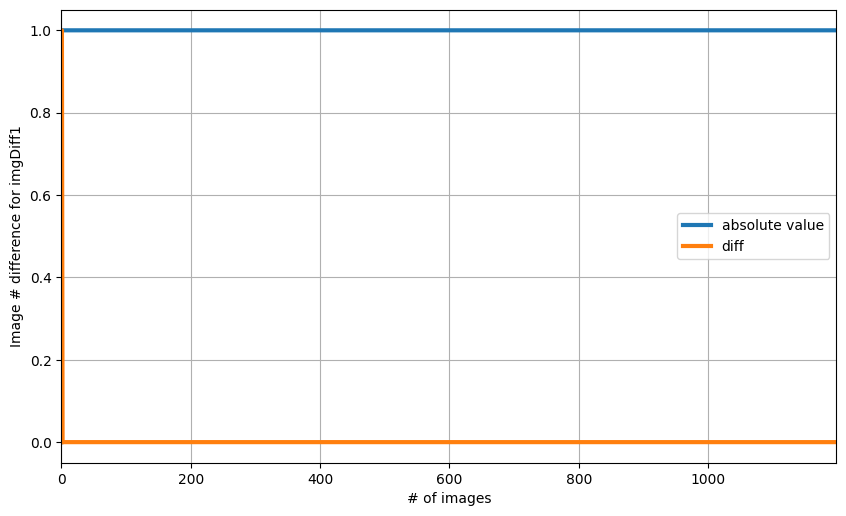

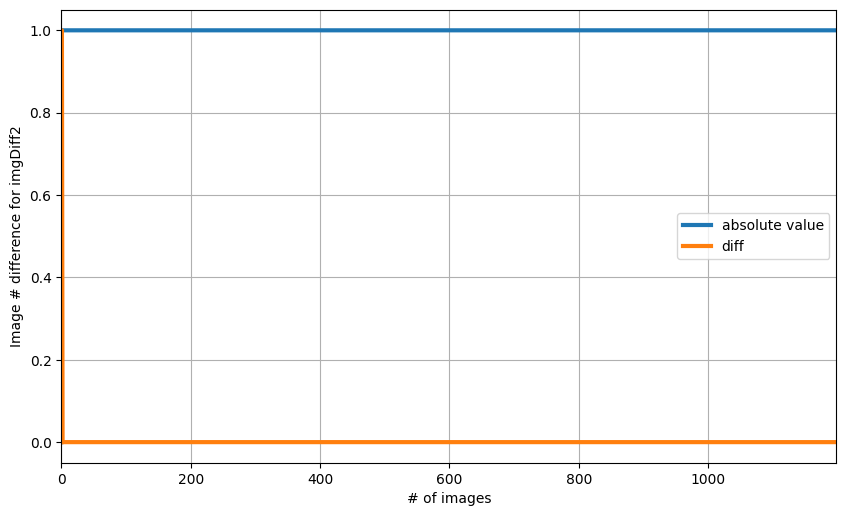

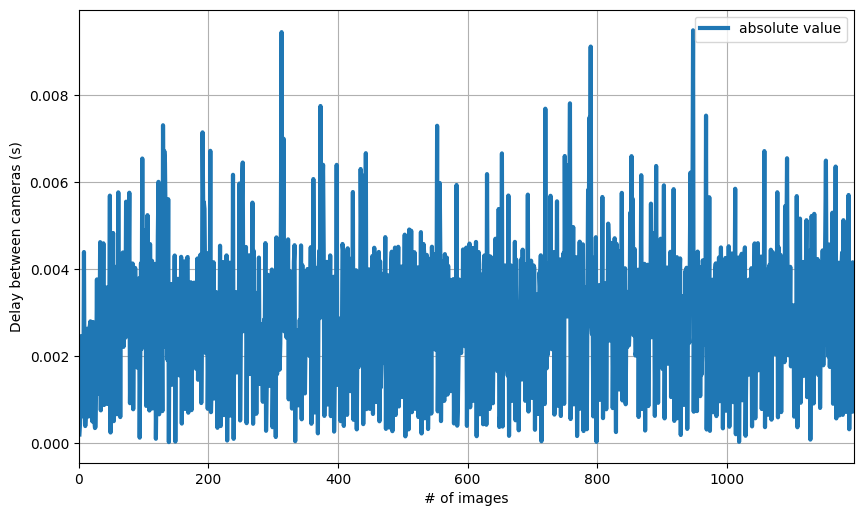

In [23]:
FPS = 40
maxDiff = 1/(FPS)/2
tresh = 10
windowLength = 10

# get valid iamges from csv timestamping
dfCam1 = pd.read_csv ('results_1.csv')    # read csv
dfCam2 = pd.read_csv ('results_2.csv')
dfCam1,dfCam2,columnsName,minLength = checkDatasets(dfCam1,dfCam2)

cam1_rows,cam2_rows,removeIdx = matchDatasets(dfCam1,dfCam2,columnsName,minLength,maxDiff,
                                                tresh,windowLength)

# get raw images path
rawCam1_Path = sorted(glob.glob("raw/camera1/*.jpg"))
rawCam2_Path = sorted(glob.glob("raw/camera2/*.jpg"))

# get clean slate for both cameras
bg1 = 'camera1.jpg'
bg2 = 'camera2.jpg'

# verbosity
verbose = 1

#select valid images
rawCam1_Path = np.array(rawCam1_Path)[cam1_rows]      
rawCam2_Path = np.array(rawCam2_Path)[cam2_rows] 

### Extracting centroids

In [56]:
# set counter for printable tracking
i = 0 
# create empy arrays for storing centers
centroidsCam1 = [0]
centroidsCam2 = [0]
# starting flags
noPrevious = 0
lastValid = 0
invalidIdx = []
cleanFolders()
map1_cam1, map2_cam1 = cv2.fisheye.initUndistortRectifyMap(cameraMatrix_cam1, distCoef_cam1, np.eye(3), cameraMatrix_cam1, (640,480), cv2.CV_16SC2)
map1_cam2, map2_cam2 = cv2.fisheye.initUndistortRectifyMap(cameraMatrix_cam1, distCoef_cam1, np.eye(3), cameraMatrix_cam1, (640,480), cv2.CV_16SC2)


print("------- Starting -------")
for i in range(0,len(rawCam1_Path),1):
    imgName1 = rawCam1_Path[i]
    # read img 2 name
    imgName2 = rawCam2_Path[i]
    text = imgName1.replace('raw/camera1\\', '', 1)
    # segment markers
    valid1,imgMasked1 = lowTreshSeg(imgName1,bg1,1)     
    valid2,imgMasked2 = lowTreshSeg(imgName2,bg2,2)     
    if not valid1 or not valid2:             
        print('Blobs in ' + text + ' cannot be identified. Discarded. ')
        if (i-lastValid) >= 10:
            nullPrev = 0
        invalidIdx.append(i)
        if not noPrevious:
            centroidsCam1 = np.zeros((4,2))
            centroidsCam2 = np.zeros((4,2))
        else:
            centroidsCam1 = np.vstack((centroidsCam1,np.zeros((4,2))))
            centroidsCam2 = np.vstack((centroidsCam2,np.zeros((4,2))))
    else:
        # find center                                  
        centerCoord1, valid1 = findBlobsCenter(imgName1,imgMasked1,cameraMatrix_cam1,distCoef_cam1,useFisheye)  
        centerCoord2, valid2 = findBlobsCenter(imgName2,imgMasked2,cameraMatrix_cam2,distCoef_cam2,useFisheye) 
        # check if they are linear
        if not valid1 or not valid2:             
            print('Blobs in ' + text + ' are not collinear. Discarded. ')
            if (i-lastValid) >= 10:
                nullPrev = 0
            invalidIdx.append(i)
            if not noPrevious:
                centroidsCam1 = np.zeros((4,2))
                centroidsCam2 = np.zeros((4,2))
            else:
                centroidsCam1 = np.vstack((centroidsCam1,np.zeros((4,2))))
                centroidsCam2 = np.vstack((centroidsCam2,np.zeros((4,2))))
        else:
            #get previous centroids
            prevCenterCoord1 = getPreviousCentroid(noPrevious, centroidsCam1[len(centroidsCam1)-4:(len(centroidsCam1)-1)])
            prevCenterCoord2 = getPreviousCentroid(noPrevious, centroidsCam2[len(centroidsCam2)-4:(len(centroidsCam2)-1)])
            # get sorted centers
            sortedCenterCoord1, otherCamOrder = orderCenterCoord(centerCoord1[0:3], prevCenterCoord1,map1_cam1,map2_cam1,imgName=imgName1, verbose=1)
            sortedCenterCoord2, _ = orderCenterCoord(centerCoord2[0:3], prevCenterCoord2,map1_cam2,map2_cam2,otherCamOrder,imgName2,1)
            if not noPrevious:
                centroidsCam1 = np.vstack((sortedCenterCoord1,centerCoord1[3]))
                centroidsCam2 = np.vstack((sortedCenterCoord2,centerCoord2[3]))
            else:
                centroidsCam1 = np.vstack((centroidsCam1, np.vstack((sortedCenterCoord1,centerCoord1[3]))))   
                centroidsCam2 = np.vstack((centroidsCam2, np.vstack((sortedCenterCoord2,centerCoord2[3]))))  
            # set flags
            noPrevious = 1
            lastValid = i
    if i % 100 == 0:                                                # tracking images processed
        print("Finished "+ str(i)+'/'+str(np.array(rawCam1_Path).shape[0]))
print("------- Finished -------")
print("Found 3 centroids in " + str(int(np.array(centroidsCam1).shape[0]/4-len(invalidIdx))) + ' images out of ' + str(int(np.array(centroidsCam1).shape[0]/4)))
print(str(len(invalidIdx))+' images were discarded.')

------- Starting -------
Finished 0/1198
Finished 100/1198
Finished 200/1198
Finished 300/1198
Finished 400/1198
Finished 500/1198
Finished 600/1198
Finished 700/1198
Finished 800/1198
Number of blobs in raw/camera1/0838.jpg is 3. Discarded. 
Blobs in raw/camera1/0838.jpg are not collinear. Discarded. 
Number of blobs in raw/camera1/0855.jpg is 3. Discarded. 
Blobs in raw/camera1/0855.jpg are not collinear. Discarded. 
Number of blobs in raw/camera1/0863.jpg is 3. Discarded. 
Blobs in raw/camera1/0863.jpg are not collinear. Discarded. 
Number of blobs in raw/camera1/0893.jpg is 3. Discarded. 
Blobs in raw/camera1/0893.jpg are not collinear. Discarded. 
Finished 900/1198
Finished 1000/1198
Finished 1100/1198
------- Finished -------
Found 3 centroids in 1194 images out of 1198
4 images were discarded.


### Triangulate

In [62]:
# saving array of centers for matlab
removeAllInvalid = np.copy(removeIdx)
if len(invalidIdx): removeAllInvalid = np.hstack((removeAllInvalid,np.array(invalidIdx)))
pts1 = np.delete(centroidsCam1.reshape(-1,4,2),removeAllInvalid,0).reshape(-1,2)
pts2 = np.delete(centroidsCam2.reshape(-1,4,2),removeAllInvalid,0).reshape(-1,2)

'''pts1 = np.copy((centroidsCam1.reshape(-1,4,2)).reshape(-1,2))
pts2 = np.copy((centroidsCam2.reshape(-1,4,2)).reshape(-1,2))'''

'pts1 = np.copy((centroidsCam1.reshape(-1,4,2)).reshape(-1,2))\npts2 = np.copy((centroidsCam2.reshape(-1,4,2)).reshape(-1,2))'

In [63]:
matstruct_contents = loadmat("../dataset32/dataRTLamb.mat")
R = matstruct_contents['R']
t = matstruct_contents['t']
lamb = matstruct_contents['lamb'][0][0]

P1 = np.hstack((cameraMatrix_cam1, [[0.], [0.], [0.]]))
P2 = np.matmul(cameraMatrix_cam2, np.hstack((R, t.T)))

projPt1 = myProjectionPoints(pts1)
projPt2 = myProjectionPoints(pts2)


points4d = cv2.triangulatePoints(P1.astype(float),
                                 P2.astype(float),
                                 projPt1.astype(float),
                                 projPt2.astype(float))
points3d = (points4d[:3, :]/points4d[3, :]).T

if points3d[0, 2] < 0:
    points3d = -points3d

In [64]:
def findPlane(A,C,D):
    x1,y1,z1 = A
    x2,y2,z2 = C
    x3,y3,z3 = D

    a1 = x2 - x1
    b1 = y2 - y1
    c1 = z2 - z1
    a2 = x3 - x1
    b2 = y3 - y1
    c2 = z3 - z1
    a = b1 * c2 - b2 * c1
    b = a2 * c1 - a1 * c2
    c = a1 * b2 - b1 * a2
    d = (- a * x1 - b * y1 - c * z1)
    return np.array([a,b,c,d])

In [65]:
L_real_AC = 15.7
L_real_AB = 10.3
L_real_BC = 5.4
L_real_AD = 14.8
L_AC_vec = []
L_BC_vec = []
L_AB_vec = []
L_AD_vec = []
k = 0
plane=np.zeros((int(len(points3d)/4),4))

for [A, B, C, D] in points3d.reshape([-1, 4, 3]):
    L_rec_AC = np.linalg.norm(A-C)
    L_rec_BC = np.linalg.norm(B-C)
    L_rec_AB = np.linalg.norm(A-B)
    L_rec_AD = np.linalg.norm(A-D)    
    L_AC_vec.append(L_rec_AC)
    L_BC_vec.append(L_rec_BC)
    L_AB_vec.append(L_rec_AB)
    L_AD_vec.append(L_rec_AD)
    plane[k] = findPlane(A*lamb/100,C*lamb/100,D*lamb/100)
    k = k + 1

### Results

Scale between real world and triang. point cloud is:  423.89
L_AC >> mean = 15.7969cm, std. dev = 0.1507cm
L_AB >> mean = 10.3739cm, std. dev = 0.114cm
L_BC >> mean = 5.4272cm, std. dev = 0.0493cm
L_AD >> mean = 14.7853cm, std. dev = 0.0978cm


(0.0, 1191.0)

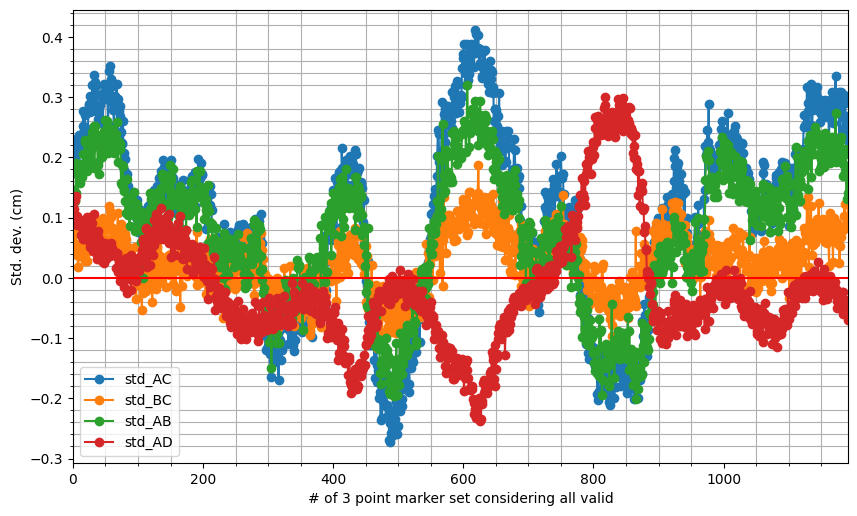

In [68]:
#cleanFolders()
print('Scale between real world and triang. point cloud is: ', lamb.round(2))
print('L_AC >> mean = ' + str((np.mean(L_AC_vec)*lamb).round(4)) +
      "cm, std. dev = " + str((np.std(L_AC_vec)*lamb).round(4)) + "cm")
print('L_AB >> mean = ' + str((np.mean(L_AB_vec)*lamb).round(4)) +
      "cm, std. dev = " + str((np.std(L_AB_vec)*lamb).round(4)) + "cm")
print('L_BC >> mean = ' + str((np.mean(L_BC_vec)*lamb).round(4)) +
      "cm, std. dev = " + str((np.std(L_BC_vec)*lamb).round(4)) + "cm")
print('L_AD >> mean = ' + str((np.mean(L_AD_vec)*lamb).round(4)) +
      "cm, std. dev = " + str((np.std(L_AD_vec)*lamb).round(4)) + "cm")
fig = plt.figure(figsize=(10, 6), dpi=100)
L_AC_vec_plot = np.array(L_AC_vec)*lamb - L_real_AC
L_BC_vec_plot = np.array(L_BC_vec)*lamb - L_real_BC
L_AB_vec_plot = np.array(L_AB_vec)*lamb - L_real_AB
L_AD_vec_plot = np.array(L_AD_vec)*lamb - L_real_AD
plt.plot(L_AC_vec_plot, '-o', label="std_AC")
plt.plot(L_BC_vec_plot, '-o', label="std_BC")
plt.plot(L_AB_vec_plot, '-o', label="std_AB")
plt.plot(L_AD_vec_plot, '-o', label="std_AD")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.grid()
#plt.axvline(x=853, c='r', linestyle='--', label="image 960")
plt.xlabel("# of 3 point marker set considering all valid")
plt.ylabel("Std. dev. (cm)")
plt.legend()
ax = fig.axes
ax[0].minorticks_on()
plt.grid(which='both')
plt.xlim(0,len(L_AD_vec)-1)

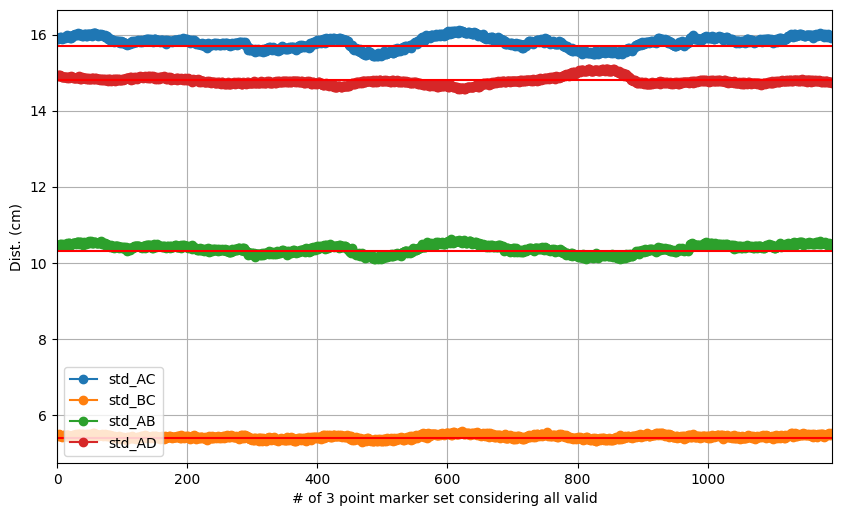

In [69]:
plt.figure(figsize=(10, 6), dpi=100)
L_AC_vec_plot = np.array(L_AC_vec)*lamb
L_BC_vec_plot = np.array(L_BC_vec)*lamb
L_AB_vec_plot = np.array(L_AB_vec)*lamb
L_AD_vec_plot = np.array(L_AD_vec)*lamb
plt.plot(L_AC_vec_plot, '-o', label="std_AC")
plt.plot(L_BC_vec_plot, '-o', label="std_BC")
plt.plot(L_AB_vec_plot, '-o', label="std_AB")
plt.plot(L_AD_vec_plot, '-o', label="std_AD")
plt.axhline(y=L_real_AC, color='r', linestyle='-')
plt.axhline(y=L_real_BC, color='r', linestyle='-')
plt.axhline(y=L_real_AB, color='r', linestyle￼='-')
plt.axhline(y=L_real_AD, color='r', linestyle='-')
plt.xlim(0,len(L_AD_vec)-1)
plt.grid()
#plt.axvline(x=853, c='r', linestyle='--', label="image 960")
plt.xlabel("# of 3 point marker set considering all valid")
plt.ylabel("Dist. (cm)")
plt.legend()


In [73]:
for i in range(0,int(len(points3d)/4)-200):
    fig = plt.figure(figsize=(8, 8))
    plt.ioff()
    ax = plt.axes(projection='3d')
    ax.set_xlim(-0.1, 3.1)
    ax.set_zlim(-0.4, 0.4)
    ax.set_ylim(-0.1, 4)
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')

    scale = 0.3
    ax.quiver(0, 0, 0, scale, 0, 0,  # x0,y0,z0,x1,y1,z1
            arrow_length_ratio=0.1, edgecolors="r")
    ax.quiver(0, 0, 0, 0, 0, scale,
            arrow_length_ratio=0.1, edgecolors="b")
    ax.quiver(0, 0, 0, 0, scale, 0,
            arrow_length_ratio=0.1, edgecolors="g")
    ax.scatter(0, 0, 0, edgecolor="blue", facecolor="black")

    x = np.array([scale, 0, 0])
    y = np.array([0, scale, 0])
    z = np.array([0, 0, scale])
    x = np.matmul(R.T, x)
    y = np.matmul(R.T, y)
    z = np.matmul(R.T, z)

    t_aux = np.matmul(-t, R)*lamb/100

    ax.quiver(t_aux[0][0], t_aux[0][2], t_aux[0][1],
            x[0], x[2], x[1], arrow_length_ratio=0.1, edgecolors="r")
    ax.quiver(t_aux[0][0], t_aux[0][2], t_aux[0][1],
            y[0], y[2], y[1], arrow_length_ratio=0.1, edgecolors="b")
    ax.quiver(t_aux[0][0], t_aux[0][2], t_aux[0][1],
            z[0], z[2], z[1], arrow_length_ratio=0.1, edgecolors="g")
    ax.scatter(t_aux[0][0], t_aux[0][2], t_aux[0][1],
            edgecolor="r", facecolor="gold")

    cmhot = plt.get_cmap("jet")

    #ax.view_init(elev=0, azim=-90)  # -37.5,30
    #ax.view_init(elev=-70, azim=-120)  # -37.5,30
    ax.view_init(elev=30, azim=-150)  # -37.5,30

    x = np.linspace(-0.1,1,30)
    y = np.linspace(-0.2,0.2,10)

    X,Y = np.meshgrid(x,y)
    Z=(-plane[i,0]*X -plane[i,1]*Y-plane[i,3])/plane[i,2]
    surf = ax.plot_surface(X,Z,Y,color='r',alpha=.3)

    ax.scatter(points3d[4*i:(4*i)+4, 0]*lamb/100, points3d[4*i:(4*i)+4, 2]*lamb/100,
            points3d[4*i:(4*i)+4, 1]*lamb/100, c='black')
    plt.gca().invert_zaxis()
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 1., .3, 1.]))
    fig.savefig("plot/"+str(i).zfill(4)+'.jpg')
    plt.close()
    
    if i % 100 == 0:                                                # tracking images processed
        print("Finished "+ str(i)+'/'+str(int(np.array(pts1).shape[0]/4)))


Finished 0/1192
Finished 100/1192
Finished 200/1192
Finished 300/1192
Finished 400/1192
Finished 500/1192
Finished 600/1192
Finished 700/1192
Finished 800/1192
Finished 900/1192


In [74]:
# save video 
path = glob.glob('plot/*.jpg')
img_array = []
for i in range(0,len(path)) :
    filename = path[i]
    img = cv2.imread(filename)
    img_array.append(img)
size = img.shape[0:2]
out = cv2.VideoWriter('plot/summary.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()